In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *

In [35]:
''' this function rectify calculate state
according to problem assumptions like maximume size of 20 for each location'''
def state_validator(value:int):
    if value>20:
        return 20
    elif value<0:
        return 0
    else :
        return value

'''this function takes current state, state value function and selected action
and returns achieved reward 
note that time period of a state is before transition cars and after
shop is closed.
reward value is consists of transition cost and rental benefit'''
def NestState_and_Reward_Calculator(current_state:list,action:int,state_value):
    returns=0
    next_state=[0,0]
    if action>=0:
        next_state[0]=current_state[0]-action
        next_state[1]=current_state[1]+action
    if action<0:
        next_state[0]=current_state[0]+action*-1
        next_state[1]=current_state[1]-action*-1
    # each car transition costs 2$
    transition_cost=np.abs(action)*-2

    avilabe_cars_to_rent_in_first_loc=next_state[0] # this is a valide number (between 0,20) because we validated actions
    avilabe_cars_to_rent_in_secound_loc=next_state[1] # this is a valide number (between 0,20) because we validated actions
    # calculating all posible next states and corresponding reward
    for rental_first_loc in range(0,poisson_upper):

        for rental_secound_loc in range(0,poisson_upper):

            rental_probs=poisson(rental_first_loc,average_request_1st_loc)*poisson(rental_secound_loc,average_request_2st_loc)
            rentaled_cars_first_loc=min(avilabe_cars_to_rent_in_first_loc,rental_first_loc)
            rentaled_cars_secound_loc=min(avilabe_cars_to_rent_in_secound_loc,rental_secound_loc)
            # each rental benefits 10$
            rental_reward=(rentaled_cars_first_loc+rentaled_cars_secound_loc)*10
          
            for return_first_loc in range(0,poisson_upper):

                for return_secound_loc in range(0,poisson_upper):

                    return_probs=poisson(return_first_loc,average_return_1st_loc)*poisson(return_secound_loc,average_return_2st_loc)

                    total_probs=return_probs*rental_probs

                    next_state_first_loc=avilabe_cars_to_rent_in_first_loc - rentaled_cars_first_loc + return_first_loc
                    next_state_secound_loc= avilabe_cars_to_rent_in_secound_loc - rentaled_cars_secound_loc + return_secound_loc
                    # validating next states 
                    next_state_first_loc=state_validator(next_state_first_loc)
                    next_state_secound_loc=state_validator(next_state_secound_loc)

                    returns+=total_probs*(rental_reward+discount_factor*state_value[next_state_first_loc][next_state_secound_loc])

      
    return transition_cost+returns
'''this function elemininate invalide actions according to th number of avilabels cars
for transition and free space of each location.'''
def action_validator(current_state:list)->list:
    actions=[]
    for i in range(0,6):
        if current_state[0]>=i and (20-current_state[1])>=i:
            actions.append(i) 
    for i in range(-5,0):
 
        if current_state[1]>=i*-1 and (20-current_state[0])>=i*-1:
            actions.append(i)
    return actions

def bellman_optimally_func(current_state:list,value_function,discount_factor:int)->float:
    values_list=[]
    for action in action_validator(current_state):
        new_value=NestState_and_Reward_Calculator(current_state,action,value_function)
        # new_value=reward+discount_factor*value_function[next_state[0]][next_state[1]]
        values_list.append(new_value)

    return max(values_list)
        

            
            
    

In [42]:
# constants
discount_factor=0.9
solved_problem_threshold=0.01
actions=[i for i in range(-5,6)] # sign assumption: +: transition from 1st location to 2st and vise versa
# first location poison distribution parameters
average_request_1st_loc=3
average_return_1st_loc=3
# secound location poison distribution parameters
average_request_2st_loc=4
average_return_2st_loc=2
# poison sampler
poisson_upper=11
pBackup={}
def poisson(x, lam):
    global pBackup
    key = x * 10 + lam
    if key not in pBackup.keys():
        pBackup[key] = np.exp(-lam) * pow(lam, x) / factorial(x)
    return pBackup[key]
# initialize value function
# states : two locations, maximum of 20 cars at each
# we create a 20*20 matrix that rows are number of cars in 1st location 
# and columns are number of cars in secound location
initial_value_func=np.ones((21,21))
updated_value_function=np.zeros((21,21))

In [43]:
def trainer(initial_value_func,updated_value_function):
    value_iteration=True
    counter=0
    while value_iteration:
        counter+=1
        old=initial_value_func.copy()
        for firs_loc in range(0,21):
            for secound_loc in range(0,21):
                current_state=[firs_loc,secound_loc]
                initial_value_func[firs_loc][secound_loc]=bellman_optimally_func(
                current_state,initial_value_func,discount_factor)
        print(np.linalg.norm(old-initial_value_func))
        if counter==4:
            break 
        if np.linalg.norm(old-initial_value_func) <=solved_problem_threshold:
            print(f'solved at {counter}ith iteration')
            value_iteration=False

    return initial_value_func
optimal_value_function=trainer(initial_value_func,updated_value_function)



3347.2104623101277
1973.000710685494
1422.9392062902077
1059.7889617080348


In [58]:
def optimal_policy_calculator(optimal_value_function):
  
    policy=np.zeros((21,21))
    values_list=[]
    actions_list=[]
    # next_stat=[0,0]
    for firs_loc in range(0,21):
        for secound_loc in range(0,21):
            current_state=[firs_loc,secound_loc]
            for action in action_validator(current_state): 
                next_state=[0,0]
                if action>=0:
                    next_state[0]=current_state[0]-action
                    next_state[1]=current_state[1]+action
                if action<0:
                    next_state[0]=current_state[0]+action*-1
                    next_state[1]=current_state[1]-action*-1
                new_value=optimal_value_function[next_state[0]][next_state[1]]
                values_list.append(new_value)
                actions_list.append(action)
            idx=np.argmax(values_list)
            optimal_action=actions_list[idx]
            policy[firs_loc][secound_loc]=optimal_action
            values_list=[]
            actions_list=[]
    return policy

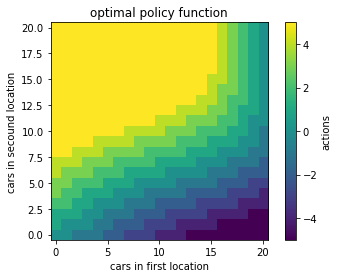

In [66]:
optimal_policy=optimal_policy_calculator(optimal_value_function)
plt.xlabel('cars in first location')
plt.ylabel('cars in secound location')
plt.title('optimal policy function')
hmap = plt.imshow(optimal_policy1, cmap='viridis', origin='lower')
cbar = plt.colorbar(hmap)
cbar.ax.set_ylabel('actions')
plt.savefig('optimal policy function',dpi=1000)

AttributeError: 'range' object has no attribute 'has_data'

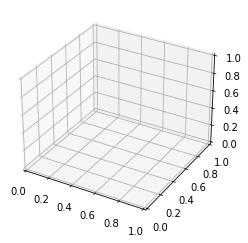

In [28]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Axes3D.scatter(range(21,),range(21,),optimal_policy)

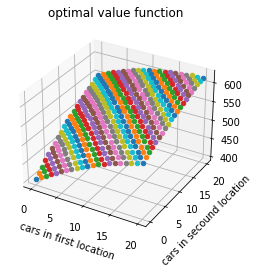

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100
plt.xlabel('cars in first location')
plt.ylabel('cars in secound location')
plt.title('optimal value function')
for x in range(0,21):
    for y in range(0,21):
        xs = x
        ys = y
        zs = optimal_value_function2[x][y]
        ax.scatter(xs, ys, zs)
plt.savefig('optimal value function',dpi=1000)

In [68]:
# save the calculated value function
with open('optimal value function.npy', 'wb') as f:
    np.save(f, optimal_value_function)